In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

In [ ]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

In [2]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

In [4]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

# Analysis of Yukawa 2-body data using Weak SINDy

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

## `std_dev=0.01`

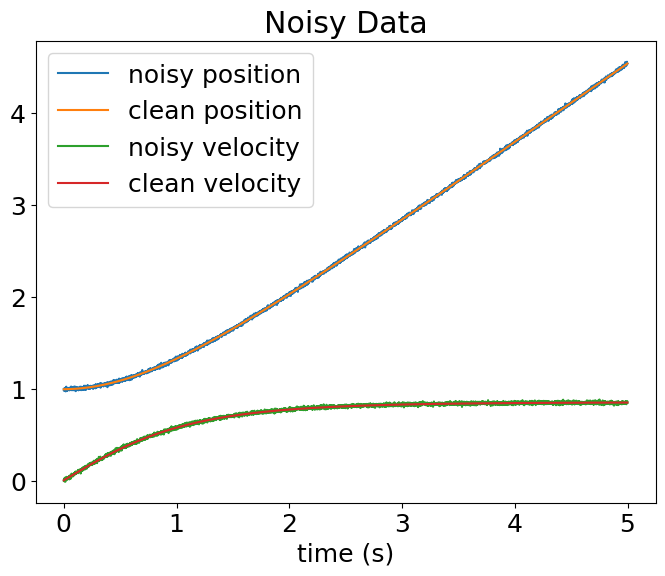

In [13]:
sim = ys.Yukawa_simulation()
sim.simulate(5)
sim.add_gaussian_noise(noise_level=0.01)
sim.plot()

In [14]:
def generate_libraries(t_for_weak):
    # define lambdas for library functions
    library_functions = [
        # lambda x: 1.0, get rid of this term because it is being duplicated and causing an error
        lambda x: x,
        lambda x: np.exp(-x) / x,
        lambda x: np.exp(-x) / x**2,
        lambda x: np.exp(-x) / x**3,
        lambda x: np.exp(-x) / x**4,
    ]

    # define names for library functions
    library_function_names = [
        # lambda x: 1,
        lambda x: x,
        lambda x: "exp(-" + x + ") / " + x,
        lambda x: "exp(-" + x + ") / " + x + "^2",
        lambda x: "exp(-" + x + ") / " + x + "^3",
        lambda x: "exp(-" + x + ") / " + x + "^4",
    ]

    # generate weak form library
    np.random.seed(120398)
    # Note: WSINDy uses a random selection of integration subdomains, so
    # we fix a seed number so we use the same set of subdomains each time
    # this function is called. 
    weak_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        spatiotemporal_grid=t_for_weak,
        function_names=library_function_names)

    # generate strong form library
    strong_lib = ps.CustomLibrary(
        library_functions=library_functions, 
        function_names=library_function_names)
    
    return weak_lib, strong_lib

In [35]:
def scan_thresholds(x_train, t_train, weak_lib, strong_lib, thresholds, verbose=False):
    # initialize variables
    if isinstance(x_train, list): multiple_trajectories = True
    else: multiple_trajectories = False
    precision = 5
    num_simeq = 3
    complexities = np.empty((2,0))
    fit_weak, fit_strong = 2*(True,)

    # loop through thresholds and fit weak and strong SINDy models to the given dataset
    for thresh in thresholds:
        # set optimizer
        opt = ps.STLSQ(threshold=thresh)
        if verbose:
            print("STLSQ threshold:", thresh)
        # fit weak model
        if fit_weak:
            weak_model = ps.SINDy(feature_names=["x", "v"],
                                feature_library=weak_lib, optimizer=opt)
            weak_model.fit(x_train, multiple_trajectories=multiple_trajectories)
            if verbose:
                print("\nWeak model")
                weak_model.print(precision=precision)
            weak_complexity = weak_model.complexity
        else:
            weak_complexity = -1

        # fit strong model
        if fit_strong:
            strong_model = ps.SINDy(feature_names=["x", "v"],
                                    feature_library=strong_lib, optimizer=opt)
            strong_model.fit(x_train, t=t_train, multiple_trajectories=multiple_trajectories)
            if verbose:
                print("\nStrong model")
                strong_model.print(precision=precision)
                print("\n" + 100*"=" + "\n")
            strong_complexity = strong_model.complexity
        else:
            strong_complexity = -1
        
        # append new complexities to list
        new_complexities = np.array([weak_complexity, strong_complexity]).reshape((2,1))
        complexities = np.append(complexities, new_complexities, axis=1)

        # stop fitting models if complexity is below num_simeq
        if weak_complexity <= num_simeq:
            fit_weak = False
        if strong_complexity <= num_simeq:
            fit_strong = False
        if not fit_weak and not fit_strong:
            break

    # change threshold to have the same dim as complexities
    num_complexities = complexities.shape[1]
    thresholds = thresholds[0:num_complexities]
        
    return thresholds, complexities


In [36]:
thresholds = np.arange(0, 0.2, 0.01)
libs = generate_libraries(sim.t)
thresholds, complexities = scan_thresholds(sim.x, sim.t, *libs, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.26790 x + -0.39245 v + 69.10195 exp(-x) / x + -0.02851 exp(-v) / v + -214.72287 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + 231.54884 exp(-x) / x^3 + -85.56737 exp(-x) / x^4
(v)' = 0.19802 x + -1.09564 v + 75.12495 exp(-x) / x + -0.00774 exp(-v) / v + -253.10291 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + 301.64100 exp(-x) / x^3 + -121.92061 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = -0.00471 x + 1.03497 v + -0.13317 exp(-x) / x + -0.03144 exp(-v) / v + 0.00343 exp(-v) / v^2 + 0.4150

With this realization of subsets of the integration subdomains, WSINDy discovers the approximately correct model with a threshold of 0.05. The interesting thing is that it does not "converge" to this value, as we continue to increase the threshold the model uses the extraneous term `exp(-v) / v` in its final model.

In [25]:
def plot_complexities(thresholds, complexities):
    fig, ax = plt.subplots(1,1)
    labels = ["Weak model", "Strong model"]
    for i in range (2):
        ax.plot(thresholds, complexities[i], 'o', label=labels[i])
    ax.hlines(3, min(thresholds), max(thresholds),linestyles='dashed', lw=1.5, label="Simulation Equations")
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(MultipleLocator(base=2))
    ax.legend()
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Number of terms")
    ax.set_title("Noise level: " + str(np.round(sim.noise_level, 2)))
    fig.tight_layout()
    return fig, ax

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

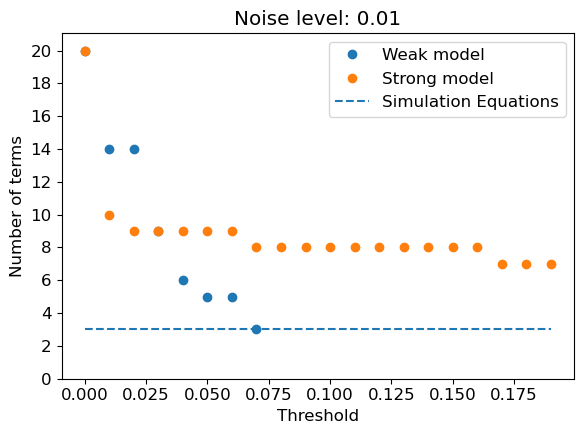

In [26]:
plt.rcParams["figure.figsize"] = (6,4.5)
plt.rcParams["font.size"] = 12
plot_complexities(thresholds, complexities)

A more complete scan reproduces the result that

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.26790 x + -0.39245 v + 69.10195 exp(-x) / x + -0.02851 exp(-v) / v + -214.72287 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + 231.54884 exp(-x) / x^3 + -85.56737 exp(-x) / x^4
(v)' = 0.19802 x + -1.09564 v + 75.12495 exp(-x) / x + -0.00774 exp(-v) / v + -253.10291 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + 301.64100 exp(-x) / x^3 + -121.92061 exp(-x) / x^4


STLSQ threshold: 0.02

Weak model
(x)' = -0.00471 x + 1.03497 v + -0.13317 exp(-x) / x + -0.03144 exp(-v) / v + 0.00343 exp(-v) / v^2 + 0.4150

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

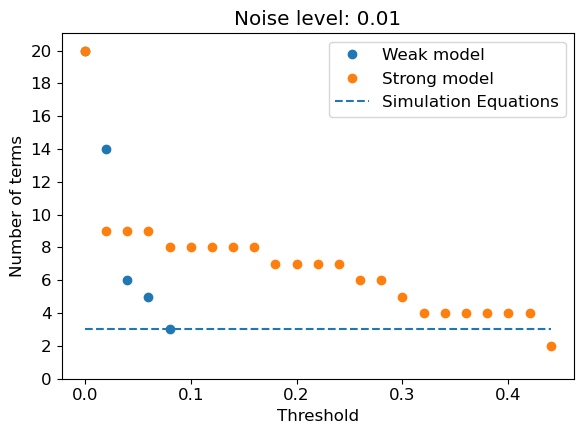

In [28]:
thresholds = np.arange(0, 0.6, 0.02)
libs = generate_libraries(sim.t)
thresholds, complexities = scan_thresholds(sim.x, sim.t, *libs, thresholds, verbose=True)
plot_complexities(thresholds, complexities)

From this, we can see that strong form discovers only the correct leading terms, but never actually discovers the correct terms, a result that we also found before.

In [ ]:
# code to be used for spot checking whatever threshold
threshold = 0.07
opt = ps.STLSQ(threshold=threshold)
weak_lib, strong_lib = generate_libraries(sim.t)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim.x)
weak_model.print(precision=5)

(x)' = 0.99776 v
(v)' = 1.79076 exp(-x) / x + 0.00921 exp(-v) / v


## `std_dev=0.10`

## Multiple trajectories

We can also generate many trajectories with different initial conditions and use that to train SINDy. This is what we were already doing for the three-body case, but we can see how much it improves the performance of SINDy here.

Note that we generate random initial conditions in the following way:

- *Initial positions*: taken from a normal distribution centered at 1 with std. dev. of 0.2
- *Initial velocities*: taken from a normal distribution centered at 0.01 with a std. dev. of 0.002, also with a random +/- sign.

This was done carefully so as to avoid there being zeros in the initial conditions, which create problems for the solver and for SINDy because of the presence of the rational terms.

In [10]:
def generate_training_data(n_sims=200, duration=5, dt=0.001, noise_level=0.01):
    # generates list of multiple trajectories with random initial conditions
    # generate init cond
    rng = np.random.default_rng(seed=4862039)
    x0s = rng.normal(1, 0.2, n_sims)
    v0s = rng.choice([-1,1], n_sims) * rng.normal(-0.01, 0.002, n_sims)
    # simulate
    sims = []
    for i in range(n_sims):
        sim = ys.Yukawa_simulation()
        sim.simulate(duration, dt=dt, x0=x0s[i], v0=v0s[i])
        sim.add_gaussian_noise(noise_level=noise_level)
        sims.append(sim)
    
    return sims

### `noise_level=0.01`

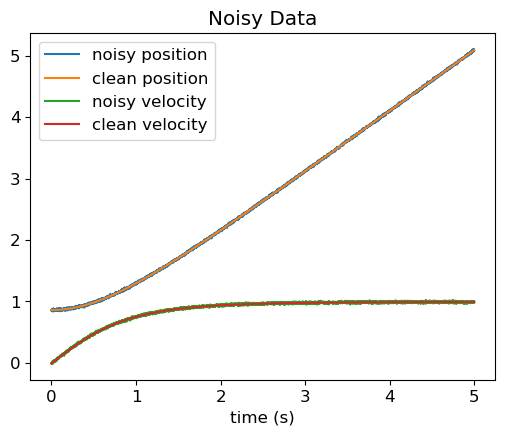

In [46]:
sims001 = generate_training_data(noise_level=0.01)
sims001[56].plot()

In [47]:
thresholds = np.arange(0, 0.2, 0.01)
libs = generate_libraries(sims001[0].t)
x_train001 = [sim.x for sim in sims001]
t_train001 = sims001[0].t
thresholds, complexities = scan_thresholds(x_train001, t_train001, *libs, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = -0.00115 x + 1.00235 v + 0.01352 exp(-x) / x + 0.00024 exp(-v) / v + -0.09098 exp(-x) / x^2 + 0.10261 exp(-x) / x^3 + -0.03314 exp(-x) / x^4
(v)' = -0.00079 x + 0.00181 v + 1.17264 exp(-x) / x + 0.00039 exp(-v) / v + 0.46554 exp(-x) / x^2 + 0.49645 exp(-x) / x^3 + -0.14327 exp(-x) / x^4

Strong model
(x)' = -0.00620 x + 1.02160 v + 0.11228 exp(-x) / x + -0.36080 exp(-x) / x^2 + 0.22707 exp(-x) / x^3 + -0.05911 exp(-x) / x^4
(v)' = 0.00051 x + -0.01911 v + 2.23923 exp(-x) / x + -2.31644 exp(-x) / x^2 + 3.00133 exp(-x) / x^3 + -0.86427 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = 0.99793 v
(v)' = 1.09565 exp(-x) / x + 0.71489 exp(-x) / x^2 + 0.25088 exp(-x) / x^3 + -0.06700 exp(-x) / x^4

Strong model
(x)' = 0.99788 v + 0.33524 exp(-x) / x + -0.87164 exp(-x) / x^2 + 0.61281 exp(-x) / x^3 + -0.15324 exp(-x) / x^4
(v)' = -0.01717 v + 2.22068 exp(-x) / x + -2.27379 exp(-x) / x^2 + 2.96908 exp(-x) / x^3 + -0.85639 exp(-x) / x^4


STLSQ thre

### `noise_level=0.10`

In [48]:
sims010 = generate_training_data(noise_level=0.10)

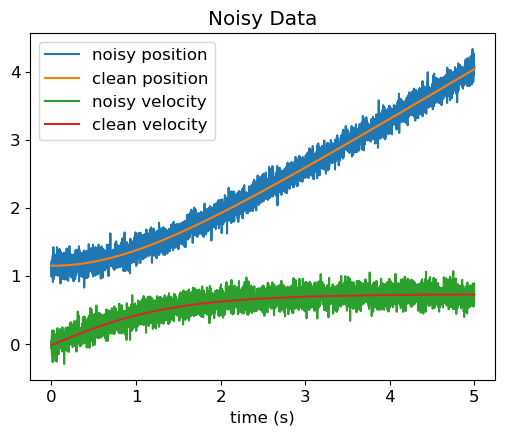

In [49]:
sims010[38].plot()

In [ ]:
# thresholds = np.arange(0, 0.2, 0.01)
thresholds = np.concatenate((np.arange(0, 0.2, 0.01), np.arange(0.2, 1.0, 0.05), np.arange(1.0, 5.0, 0.5)))
libs = generate_libraries(sims010[0].t)
x_train010 = [sim.x for sim in sims010]
t_train010 = sims010[0].t
thresholds, complexities = scan_thresholds(x_train010, t_train010, *libs, thresholds)

STLSQ threshold: 0.0

Weak model
(x)' = -0.00884 x + 1.01334 v + 0.12219 exp(-x) / x + -0.00004 exp(-v) / v + -0.57242 exp(-x) / x^2 + 0.52571 exp(-x) / x^3 + -0.13753 exp(-x) / x^4
(v)' = -0.00434 x + 0.00521 v + 2.52434 exp(-x) / x + 0.00004 exp(-v) / v + -3.12422 exp(-x) / x^2 + 3.27686 exp(-x) / x^3 + -0.82483 exp(-x) / x^4

Strong model
(x)' = -0.00013 exp(-v) / v
(v)' = -0.00046 exp(-v) / v


STLSQ threshold: 0.01

Weak model
(x)' = 0.98175 v + 0.08056 exp(-x) / x + -0.27180 exp(-x) / x^2 + 0.13947 exp(-x) / x^3
(v)' = 1.32029 exp(-x) / x + 0.26025 exp(-x) / x^2 + 0.28283 exp(-x) / x^3

Strong model
(x)' = 0.24977 x + -0.04620 v + 2.65841 exp(-x) / x + -4.69039 exp(-x) / x^2 + 2.90515 exp(-x) / x^3 + -0.76177 exp(-x) / x^4
(v)' = 0.07183 x + -0.41109 v + 9.24765 exp(-x) / x + -13.98304 exp(-x) / x^2 + 8.70432 exp(-x) / x^3 + -1.94649 exp(-x) / x^4


STLSQ threshold: 0.02

Weak model
(x)' = 0.98264 v + -0.12565 exp(-x) / x^2 + 0.07671 exp(-x) / x^3
(v)' = 1.32029 exp(-x) / x + 0.2

In [55]:
thresholds = np.concatenate((np.arange(0, 0.2, 0.01), np.arange(0.2, 1.0, 0.05), np.arange(1.0, 5.0, 0.5)))

In [52]:
thresholds = np.arange(0.2, 1.0, 0.05)
thresholds, complexities = scan_thresholds(x_train010, t_train010, *libs, thresholds, verbose=True)

STLSQ threshold: 0.2

Weak model
(x)' = 0.97920 v
(v)' = 1.02562 exp(-x) / x + 0.86036 exp(-x) / x^2

Strong model
(x)' = 0.23899 x + 2.30190 exp(-x) / x + -4.05377 exp(-x) / x^2 + 2.54814 exp(-x) / x^3 + -0.70112 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


STLSQ threshold: 0.25

Strong model
(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


STLSQ threshold: 0.3

Strong model
(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


STLSQ threshold: 0.35

Strong model
(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x

In [53]:
thresholds = np.arange(1.0, 5.0, 0.5)
thresholds, complexities = scan_thresholds(x_train010, t_train010, *libs, thresholds, verbose=True)

STLSQ threshold: 1.0


c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(



Weak model
(x)' = 0.00000
(v)' = 1.88520 exp(-x) / x

Strong model
(x)' = 10.79840 exp(-x) / x + -12.52188 exp(-x) / x^2 + 2.99648 exp(-x) / x^3
(v)' = 4.13428 exp(-x) / x^2 + -2.15144 exp(-x) / x^3


STLSQ threshold: 1.5

Strong model
(x)' = 10.79840 exp(-x) / x + -12.52188 exp(-x) / x^2 + 2.99648 exp(-x) / x^3
(v)' = 4.13428 exp(-x) / x^2 + -2.15144 exp(-x) / x^3


STLSQ threshold: 2.0


c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (2.0) and eliminated all coefficients
  warnings.warn(



Strong model
(x)' = 10.79840 exp(-x) / x + -12.52188 exp(-x) / x^2 + 2.99648 exp(-x) / x^3
(v)' = 0.00000




In [ ]:
x_train = [sim.x for sim in sims010] # if sim.x.shape[0] == 5000]
t_train = sims010[0].t
weak_lib, strong_lib = generate_libraries(t_train)

In [40]:
opt = ps.STLSQ(threshold=0.5)
strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
strong_model.fit(x_train, t=t_train, multiple_trajectories=True)
strong_model.print(precision=5)

(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


In [41]:
opt = ps.STLSQ(threshold=0.2)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

(x)' = 0.97920 v
(v)' = 1.02562 exp(-x) / x + 0.86036 exp(-x) / x^2


### `noise_level=0.5`